<a href="https://colab.research.google.com/github/vu-topics-in-big-data-2021/project-crypto-group16/blob/main/Query5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Query 5: use rolling window to find correlation values

In [1]:
#install the required packages
!pip3 install influxdb plotly pandas numpy matplotlib

     |████████████████████████████████| 81kB 3.7MB/s 


In [2]:
from influxdb import InfluxDBClient
import json
from datetime import datetime
from getpass import getpass
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pylab import rcParams
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [3]:
covid_client = InfluxDBClient(host='3.85.177.70', username='admin', password='dudgus06', port=8086, database="covid")
forex_client = InfluxDBClient(host='100.25.103.36', username='hunter', password='hcb', port=8086, database="crypto_forex")

In [4]:
# Assuming you have created the energy database through influxd CLI. 
# Now, test the connection status...
print('existing databases for covid data:', covid_client.get_list_database())
print('existing databases for forex data:', forex_client.get_list_database())

existing databases for covid data: [{'name': '_internal'}, {'name': 'covid'}, {'name': 'crypto'}]
existing databases for forex data: [{'name': '_internal'}, {'name': 'crypto_forex'}]


## Load data from influxDB and store to pandas dataframes

In [6]:
country = 'USA'
pairs = ['C:EURUSD', 'C:GBPUSD', 'C:JPYUSD', 'C:CNYUSD', 'X:BTCUSD']

def daily_new(country):
  query_str = 'SELECT mean("daily_new_cases") AS "mean" FROM covid WHERE time > \'2020-02-14T00:00:00Z\' AND time < \'2021-04-01T00:00:00Z\' AND "country"=\'{}\' GROUP BY time(7d) FILL(null)'.format(country)
  
  try:
    result = pd.DataFrame(covid_client.query(query_str).get_points('covid'))
  except Exception as e:
    print(e)

  return result

def mean_close(pair):
    query_str='SELECT mean("c") AS "mean" FROM crypto_forex WHERE time > \'2020-02-14T00:00:00Z\' AND time < \'2021-04-01T00:00:00Z\' AND "pair"=\'{}\' GROUP BY time(7d) FILL(null)'.format(pair)
    
    try:
      result = pd.DataFrame(forex_client.query(query_str).get_points('crypto_forex'))
    except Exception as e:
      print(e)

    return result

def join(df, pairList):
  for i in pairList:
    tmp_df = mean_close(i)
    if df.empty:
      df = tmp_df
    else:
      new_df = pd.merge(left=df,
                        right=tmp_df,
                        how="left",
                        on = "time",
                        left_index=True)
      df = new_df.rename(columns={'mean':i})
  
  return df

covid_result = daily_new(country).rename(columns={'mean':country})
data = join(covid_result, pairs)
data.head(3)

,time,USA,C:EURUSD,C:GBPUSD,C:JPYUSD,C:CNYUSD,X:BTCUSD
0,2020-02-13T00:00:00Z,0.000000,1.082154,1.300249,0.009082,0.142975,9994.197420
1,2020-02-20T00:00:00Z,6.428571,1.084170,1.293247,0.009001,0.142179,9580.076244
2,2020-02-27T00:00:00Z,14.000000,1.108014,1.286300,0.009240,0.143137,8723.392328


## Plot daily COVID-19 cases and closing value of currencies
Using rolling time window, plot the correlation values

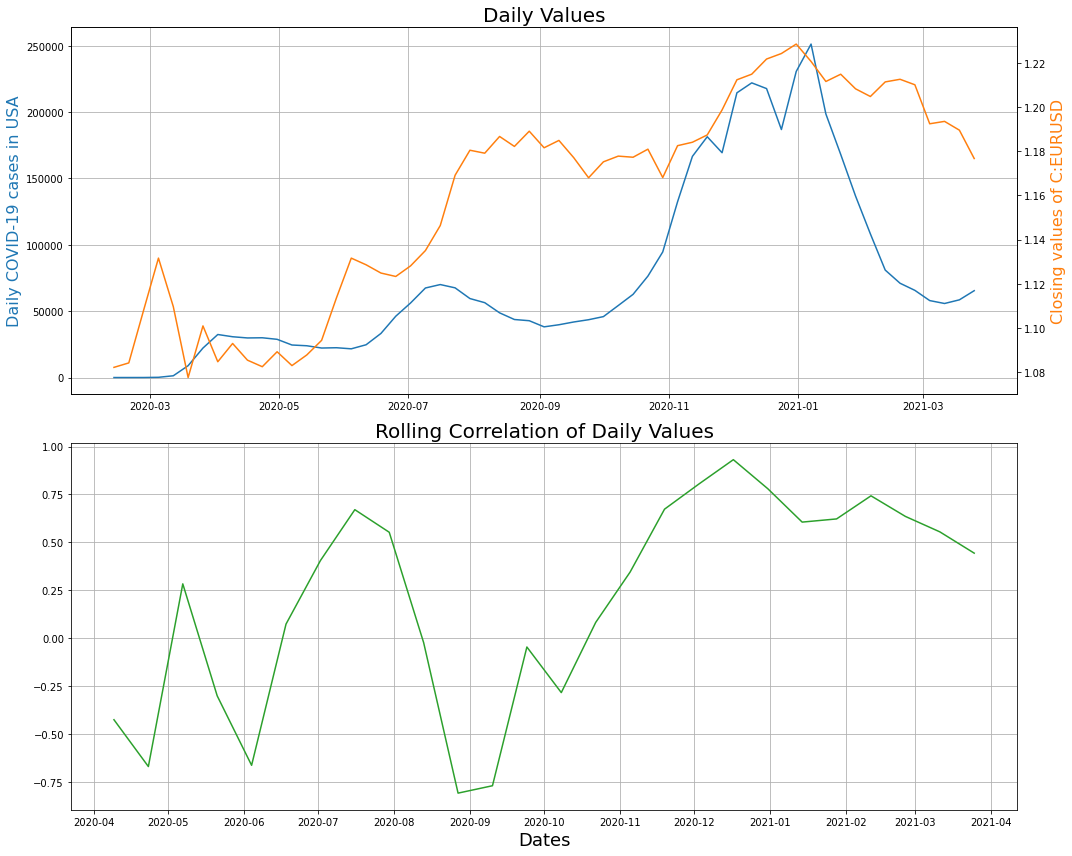

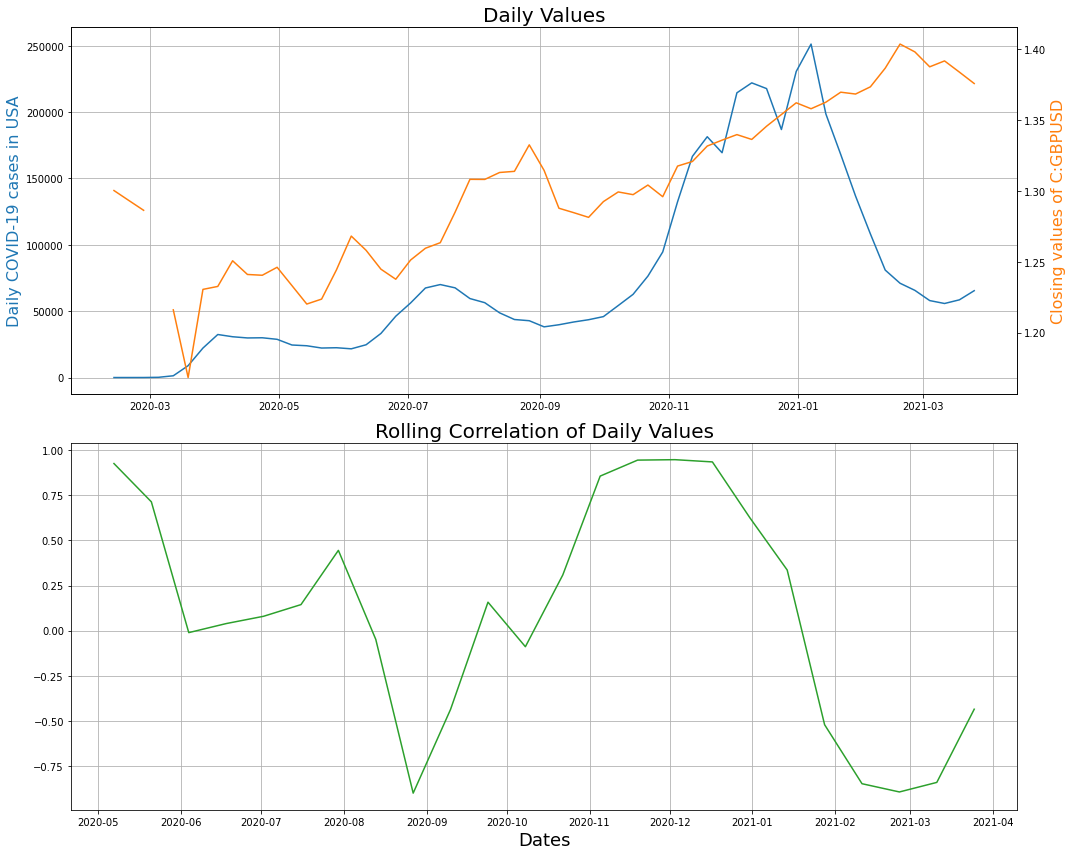

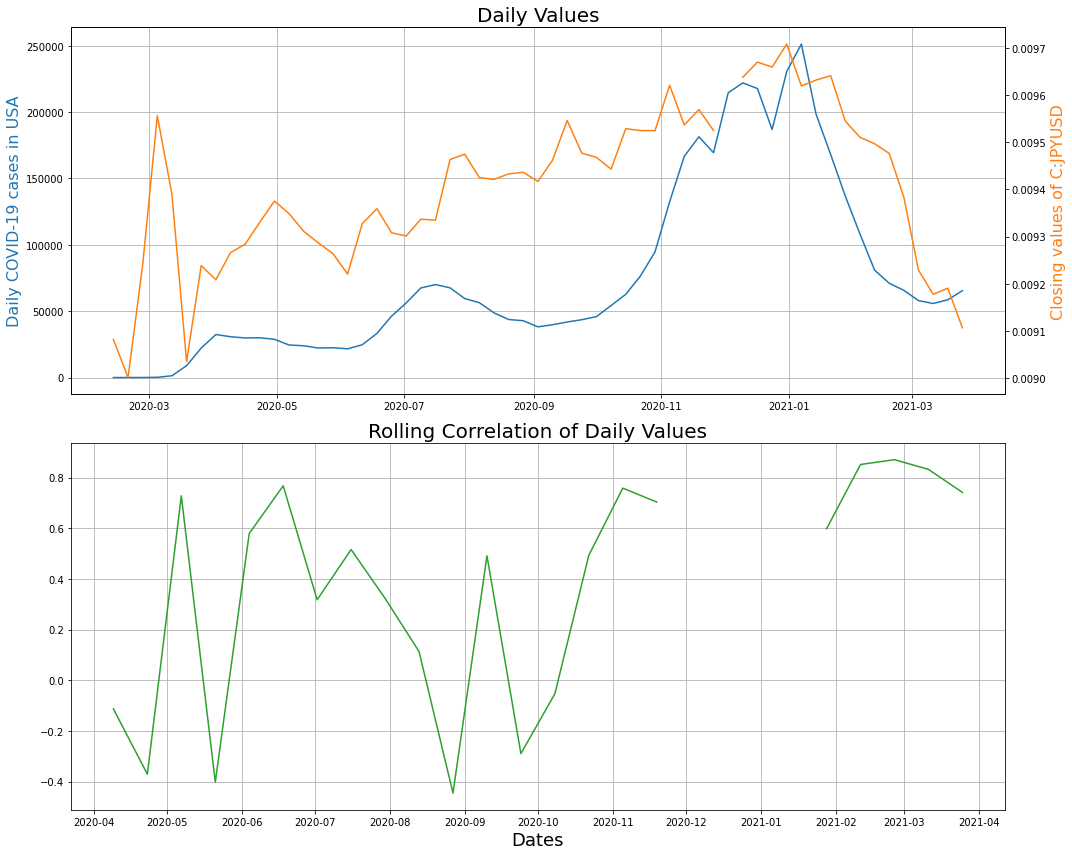

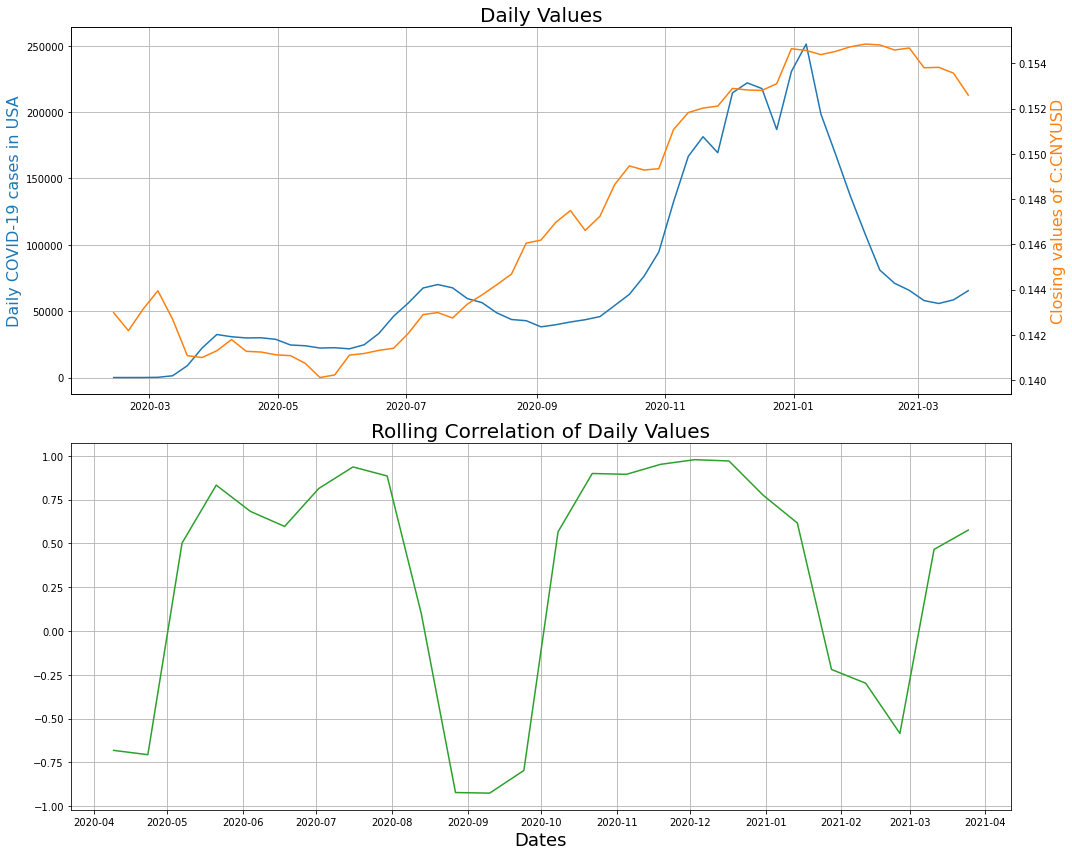

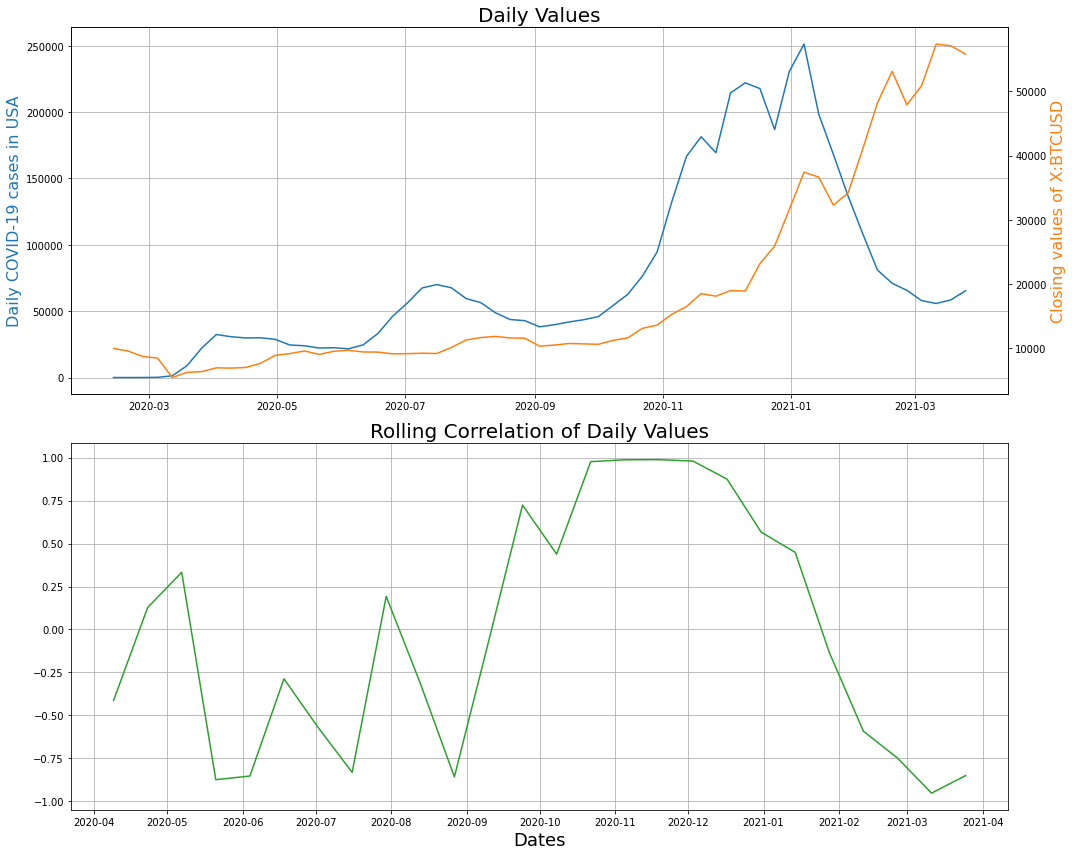

In [8]:
def monthly_ticks(axs, i, x, y, c, t):
  axs[i].plot(x, y, color = c)
  axs[i].set_title(t, fontsize = 20)

  fmt_month = mdates.MonthLocator(interval=1)
  axs[i].xaxis.set_major_locator(fmt_month)

  axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

  axs[i].format_xdata = mdates.DateFormatter('%Y-%m')
  axs[i].grid(True)

def plot_rolling(country, currency, data):
  titles = ['Daily Values', 'Rolling Correlation of Daily Values']

  fig, axs = plt.subplots(2, figsize=(15, 12))
  timesteps = [datetime.strptime(r[:10], '%Y-%m-%d') for r in data['time']]
  monthly_ticks(axs, 0, timesteps, data[country], '#1f77b4', titles[0])

  ax2 = axs[0].twinx()
  ax2.plot(timesteps, data[currency], color = '#ff7f0e')
  axs[0].set_ylabel('Daily COVID-19 cases in {}'.format(country), color='#1f77b4', fontsize = 16)
  ax2.set_ylabel('Closing values of {}'.format(currency), color='#ff7f0e', fontsize = 16)

  rolling_corr = data[country].rolling(8).corr(data[currency])[::2]
  rolling_timesteps = timesteps[::2]
  monthly_ticks(axs, 1, rolling_timesteps, rolling_corr, '#2ca02c', titles[1])
  axs[1].set_xlabel("Dates", fontsize = 18)

  plt.tight_layout()
  plt.show()
  # uncomment to save figure
  #plt.savefig("rollingCorr_{}.png".format(currency))
  return rolling_corr

for i in range(len(pairs)):
  rolling_corr = plot_rolling(country, pairs[i], data)

# Shift closing values by two months (4 data points) and look at correlation values again

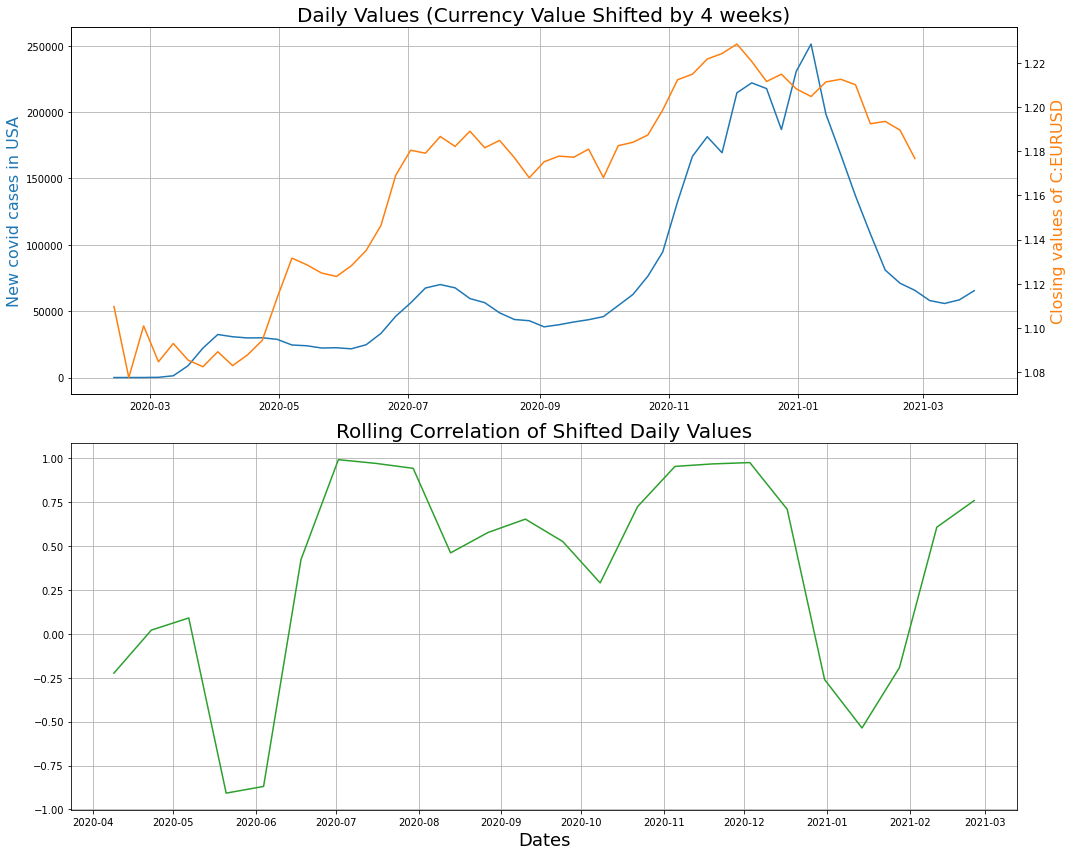

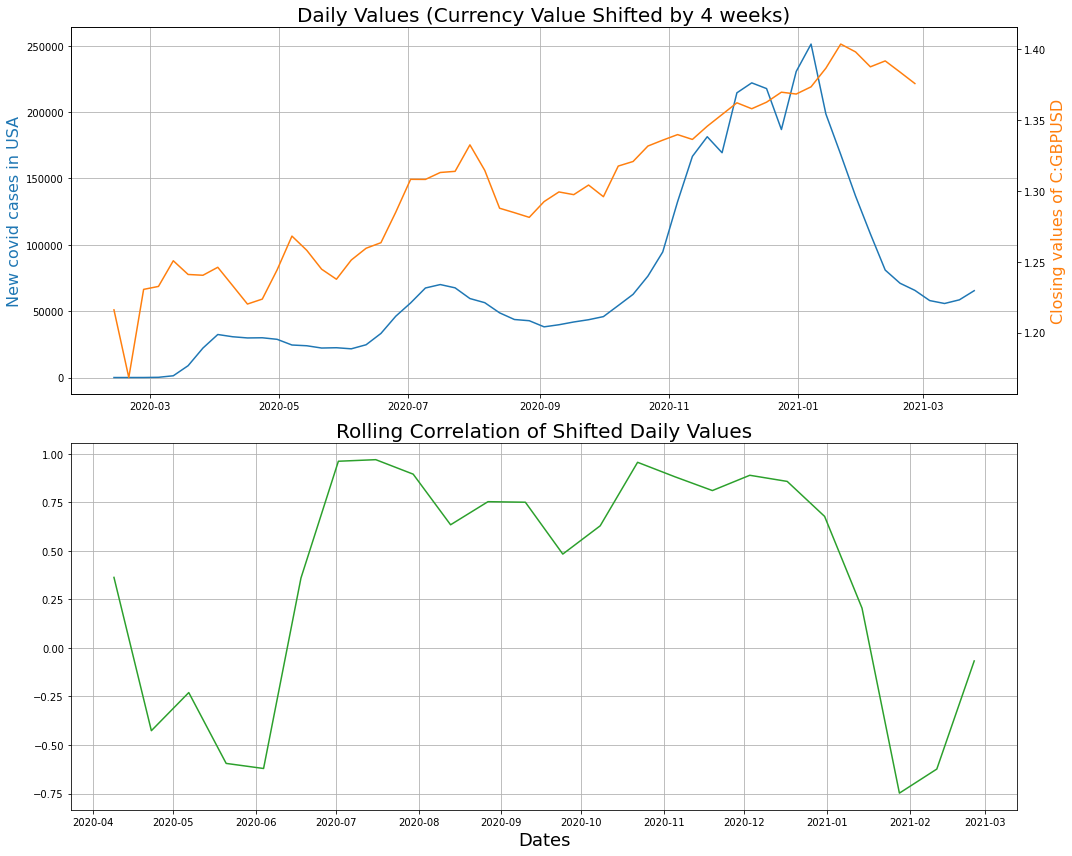

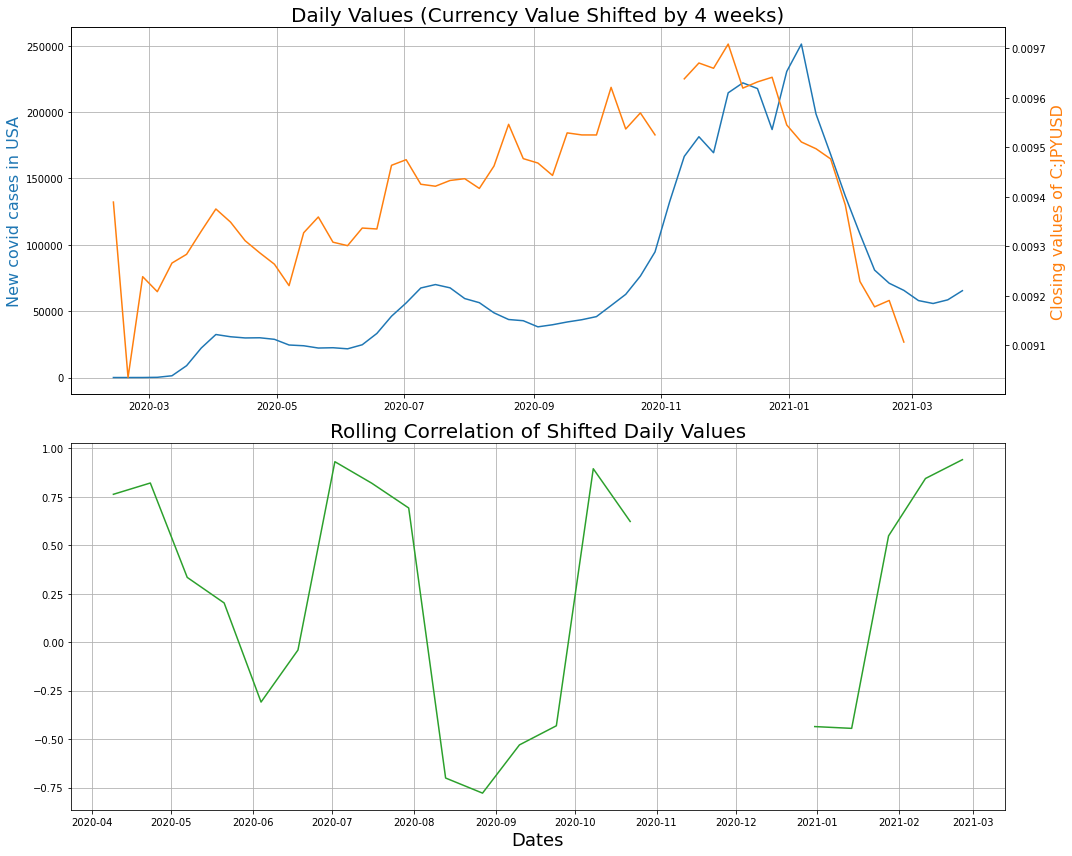

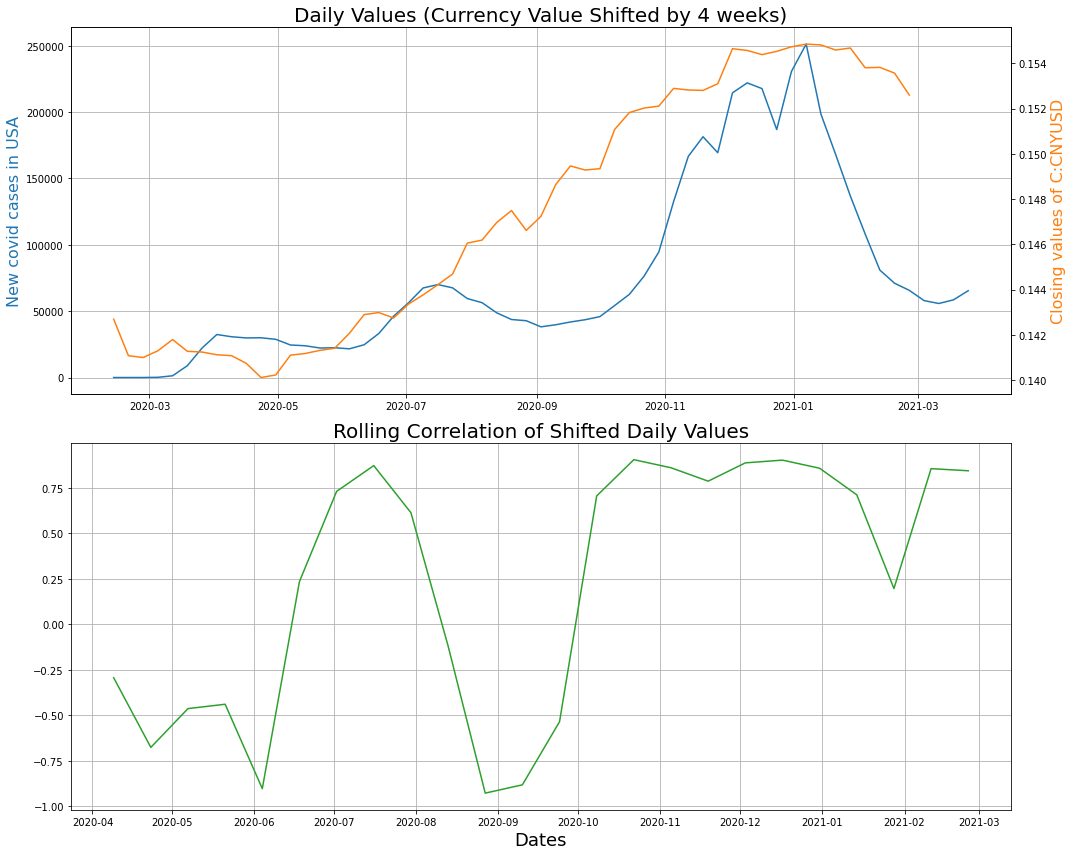

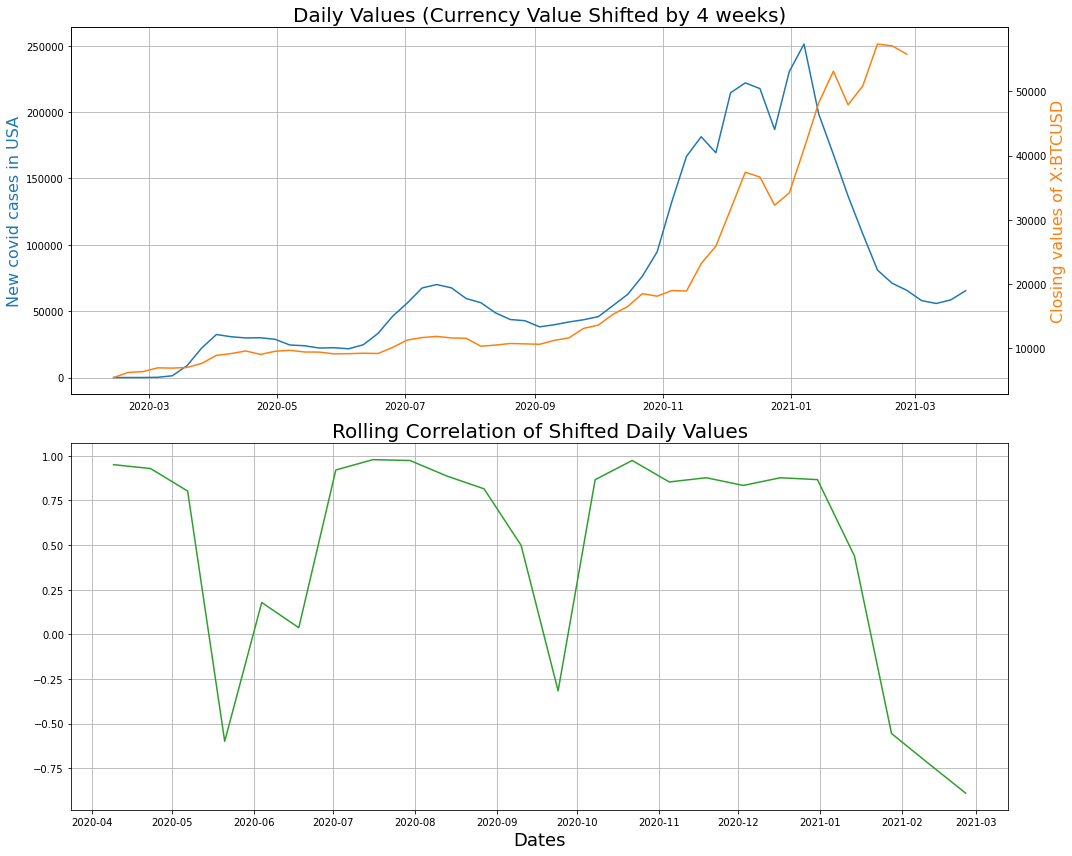

In [9]:
def plot_rolling_shifted(country, currency, data):
  titles = ['Daily Values (Currency Value Shifted by 4 weeks)', 'Rolling Correlation of Shifted Daily Values']

  fig, axs = plt.subplots(2, figsize=(15, 12))
  timesteps = [datetime.strptime(r[:10], '%Y-%m-%d') for r in data['time']]
  monthly_ticks(axs, 0, timesteps, data[country], '#1f77b4', titles[0])

  ax2 = axs[0].twinx()
  ax2.plot(timesteps[:-4], data[currency][4:], color = '#ff7f0e')
  axs[0].set_ylabel('New covid cases in {}'.format(country), color='#1f77b4', fontsize = 16)
  ax2.set_ylabel('Closing values of {}'.format(currency), color='#ff7f0e', fontsize = 16)

  c = data[country][:-4]
  f = data[currency][4:]
  t = timesteps[:-4]
  df = pd.DataFrame([t, c, f]).transpose()
  df.columns = ['time', country, currency]
  df = df.set_index('time')
  rolling = df[country].rolling(8).corr(df[currency])[::2]

  monthly_ticks(axs, 1, t[::2], rolling, '#2ca02c', titles[1])
  axs[1].set_xlabel("Dates", fontsize = 18)

  plt.tight_layout()
  #plt.show()
  # uncomment to save figure files
  plt.savefig("rollingCorr_shifted_{}.png".format(currency))

for i in range(len(pairs)):
  plot_rolling_shifted(country, pairs[i], data)